When running active learning it's usually a good idea to start off "simple" and make the system/structures gradually more complicated.

To train liquid water, we here

* first train a potential at slightly above room temperature and 1.0 g/cm^3

* continue with a second active learning loop where the density is explicitly scanned from a low to a high value

## Initial imports

In [2]:
import scm.plams as plams
from scm.simple_active_learning import SimpleActiveLearningJob
import matplotlib.pyplot as plt
from scm.external_engines.core import interface_is_installed

assert interface_is_installed(
    "m3gnet"
), "You must install the m3gnet backend before following this tutorial!"

In [2]:
plams.init()

PLAMS working folder: /home/hellstrom/adfhome/userdoc/Workflows/SimpleActiveLearning/PythonExamples/SALLiquidWater/plams_workdir.003


## Create an initial water box

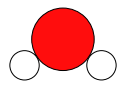

In [3]:
water = plams.from_smiles("O")
for at in water:
    at.properties = plams.Settings()
plams.plot_molecule(water)

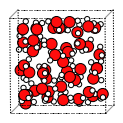

In [200]:
box = plams.packmol(water, n_molecules=48, density=1.0)
plams.plot_molecule(box, rotation="-5x,5y,0z")

Let's run a short MD simulation with M3GNet-UP-2022 to make the structure more realistic:

In [5]:
up_s = plams.Settings()
up_s.input.MLPotential.Model = "M3GNet-UP-2022"
up_s.runscript.nproc = 1  # always run AMS Driver in serial for MLPotential
up_md = plams.AMSNVTJob(
    molecule=box,
    settings=up_s,
    name="up_md",
    nsteps=1000,
    timestep=0.5,
    temperature=350,
)
up_md.run();

[22.02|09:51:37] JOB up_md STARTED
[22.02|09:51:37] JOB up_md RUNNING
[22.02|09:52:19] JOB up_md FINISHED
[22.02|09:52:20] JOB up_md SUCCESSFUL


New structure:

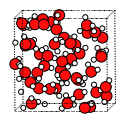

In [6]:
starting_structure = up_md.results.get_main_molecule()
plams.plot_molecule(starting_structure, rotation="-5x,5y,0z")

## Simple Active Learning setup

### Reference engine settings

Here, we choose to train against ReaxFF Water-2017.ff, which gives a good water structure.

In [5]:
fast_ref_s = plams.Settings()
fast_ref_s.input.ReaxFF.ForceField = "Water2017.ff"
fast_ref_s.runscript.nproc = 1

slow_ref_s = plams.Settings()
slow_ref_s.input.QuantumESPRESSO.Pseudopotentials.Family = "SSSP-Efficiency"
slow_ref_s.input.QuantumESPRESSO.Pseudopotentials.Functional = "PBE"
slow_ref_s.input.QuantumESPRESSO.K_Points._h = "gamma"
slow_ref_s.input.QuantumESPRESSO.System = plams.Settings(
    input_dft="revpbe", ecutwfc=40, vdw_corr="Grimme-D3", dftd3_version=4
)

Change to slow_ref_s to train to revPBE-D3(BJ) instead:

In [9]:
ref_s = fast_ref_s.copy()

### NVT molecular dynamics settings

In [16]:
nvt_md_s = plams.AMSNVTJob(
    nsteps=20000,
    timestep=0.5,
    temperature=(270, 350, 350),
    tau=100,
    thermostat="Berendsen",
).settings

### ParAMS machine learning settings

In [17]:
ml_s = plams.Settings()
ml_s.input.ams.MachineLearning.Backend = "M3GNet"
ml_s.input.ams.MachineLearning.CommitteeSize = 1
ml_s.input.ams.MachineLearning.M3GNet.Model = "UniversalPotential"
ml_s.input.ams.MachineLearning.MaxEpochs = 200

### Active learning settings

Liquid water is a "simple" homogeneous system, so we can expect the ML method to perform quite well. We therefore decrease the success criteria thresholds a bit compared to the default vvalues, to ensure that we get accurate results.

Since we will immediately continue with another active learning loop, we disable the "RerunSimulation" as we are not interested in the MD simulation per se.

In [18]:
al_s = plams.Settings()
al_s.input.ams.ActiveLearning.Steps.Type = "Geometric"
al_s.input.ams.ActiveLearning.Steps.Geometric.Start = 10
al_s.input.ams.ActiveLearning.Steps.Geometric.NumSteps = 8
al_s.input.ams.ActiveLearning.InitialReferenceData.Generate.M3GNetShortMD.Enabled = "Yes"
al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Relative = 0.003
al_s.input.ams.ActiveLearning.SuccessCriteria.Forces.MaxDeviationForZeroForce = 0.35
al_s.input.ams.ActiveLearning.AtEnd.RerunSimulation = "No"

### Complete job

In [199]:
settings = ref_s + nvt_md_s + ml_s + al_s
job = SimpleActiveLearningJob(settings=settings, molecule=starting_structure, name="sal")
print(job.get_input())

ActiveLearning
  AtEnd
    RerunSimulation False
  End
  InitialReferenceData
    Generate
      M3GNetShortMD
        Enabled True
      End
    End
  End
  Steps
    Geometric
      NumSteps 8
      Start 10
    End
    Type Geometric
  End
  SuccessCriteria
    Energy
      Relative 0.003
    End
    Forces
      MaxDeviationForZeroForce 0.35
    End
  End
End
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 300
End
MolecularDynamics
  BinLog
    DipoleMoment False
    PressureTensor False
    Time False
  End
  CalcPressure False
  Checkpoint
    Frequency 1000000
  End
  InitialVelocities
    Temperature 270.0
    Type Random
  End
  NSteps 20000
  Thermostat
    Duration 10000 10000
    Tau 100.0
    Temperature 270.0 350.0 350.0
    Type Berendsen
  End
  TimeStep 0.5
  Trajectory
    SamplingFreq 100
    WriteBonds True
    WriteCharges True
    WriteEngineGradients False
    WriteMolecules True
    WriteVelocities True


### Run the simple active learning job

In [20]:
job.run(watch=True);

[22.02|10:12:07] JOB sal STARTED
[22.02|10:12:07] Renaming job sal to sal.002
[22.02|10:12:07] JOB sal.002 RUNNING
[22.02|10:12:09] Simple Active Learning 2024.101,  Nodes: 1, Procs: 1
[22.02|10:12:11] Composition of main system: H96O48
[22.02|10:12:11] All REFERENCE calculations will be performed with the following ReaxFF engine:
[22.02|10:12:11]
Engine reaxff
  forcefield Water2017.ff
EndEngine


[22.02|10:12:11] The following are the settings for the to-be-trained MACHINE LEARNING model:
[22.02|10:12:11]
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 300
End

ParallelLevels
End

[22.02|10:12:11] A single model will be trained (no committee).
[22.02|10:12:11] The ACTIVE LEARNING loop will contain 8 steps, using the following schema:
[22.02|10:12:11]    Active Learning Step   1:       10 MD Steps (cumulative:       10)
[22.02|10:12:11]    Active Learning Step   2:       19 MD Steps (cumulative:       29)
[22.02|10:12:11]    A

## Validate trained model by RDF and MSD

Note: You should skip this part if you trained to DFT since the reference MD calculation will take a very long time!

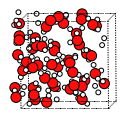

In [23]:
mol = job.results.get_main_molecule()
plams.plot_molecule(mol, rotation="-5x,5y,0z")

In [57]:
retrained_model_settings = (
    job.results.get_params_job().results.get_production_engine_settings()
)
retrained_model_settings.runscript.nproc = 1

### Equilibration and production MD settings

In [62]:
eq_md_settings = plams.AMSNVTJob(
    nsteps=8000,
    timestep=0.5,
    thermostat="Berendsen",
    tau=100,
    temperature=300,
    samplingfreq=100,
).settings

prod_md_settings = plams.AMSNVTJob(
    nsteps=50000,
    timestep=0.5,
    thermostat="NHC",
    tau=200,
    temperature=300,
    samplingfreq=100,
).settings

### Retrained model equilibration

In [63]:
retrained_model_eq_md_job = plams.AMSJob(
    settings=eq_md_settings + retrained_model_settings,
    molecule=mol,
    name="retrained_model_eq_md_dens_1",
)
retrained_model_eq_md_job.run();

[22.02|13:39:24] JOB eq_md_dens_1 STARTED
[22.02|13:39:24] Renaming job eq_md_dens_1 to eq_md_dens_1.003
[22.02|13:39:24] JOB eq_md_dens_1.003 RUNNING
[22.02|13:42:58] JOB eq_md_dens_1.003 FINISHED
[22.02|13:42:58] JOB eq_md_dens_1.003 SUCCESSFUL


### Retrained model production simulation

Let's then run a production simulation from the final structure of the above equilibration MD using both the retrained model and the reference engine:

In [70]:
retrained_model_prod_md_job = plams.AMSJob(
    settings=prod_md_settings + retrained_model_settings,
    name="retrained_model_prod_md_dens_1",
    molecule=retrained_model_eq_md_job.results.get_main_molecule(),
)
retrained_model_prod_md_job.run();

[22.02|13:46:22] JOB retrained_model_prod_md_dens_1 STARTED
[22.02|13:46:22] Renaming job retrained_model_prod_md_dens_1 to retrained_model_prod_md_dens_1.005
[22.02|13:46:22] JOB retrained_model_prod_md_dens_1.005 RUNNING
[22.02|14:07:30] JOB retrained_model_prod_md_dens_1.005 FINISHED
[22.02|14:07:30] JOB retrained_model_prod_md_dens_1.005 SUCCESSFUL


### Reference equilibration MD

In [76]:
reference_eq_md_job = plams.AMSJob(
    settings=eq_md_settings + ref_s,
    molecule=mol,
    name="reference_eq_md_dens_1",
)
reference_eq_md_job.run();

[22.02|14:08:55] JOB reference_eq_md_dens_1 STARTED
[22.02|14:08:55] JOB reference_eq_md_dens_1 RUNNING
[22.02|14:09:19] JOB reference_eq_md_dens_1 FINISHED
[22.02|14:09:19] JOB reference_eq_md_dens_1 SUCCESSFUL


### Reference production MD

In [77]:
reference_prod_md_job = plams.AMSJob(
    settings=prod_md_settings + ref_s,
    name="reference_prod_md_dens_1",
    molecule=reference_eq_md_job.results.get_main_molecule(),
)
reference_prod_md_job.run();

[22.02|14:09:19] JOB reference_prod_md_dens_1 STARTED
[22.02|14:09:19] Renaming job reference_prod_md_dens_1 to reference_prod_md_dens_1.003
[22.02|14:09:19] JOB reference_prod_md_dens_1.003 RUNNING
[22.02|14:11:59] JOB reference_prod_md_dens_1.003 FINISHED
[22.02|14:11:59] JOB reference_prod_md_dens_1.003 SUCCESSFUL


### Mean squared displacement (MSD) helper functions

For a detailed explanation of the MSD and RDF jobs, see the "Molecular dynamics with Python" tutorial

In [182]:
def get_msd_job(job: plams.AMSJob, symbol: str = "O"):
    atom_indices = [
        i
        for i, at in enumerate(job.results.get_main_molecule(), 1)
        if at.symbol == symbol
    ]

    msd_job = plams.AMSMSDJob(
        job,
        name="msd-" + job.name,
        atom_indices=atom_indices,  # indices start with 1 for the first atom
        max_correlation_time_fs=4000,  # max correlation time must be set before running the job
        start_time_fit_fs=2000,  # start_time_fit can also be changed later in the postanalysis
    )
    msd_job.run()

    return msd_job


def plot_msd(job, start_time_fit_fs=None):
    """job: an AMSMSDJob"""
    time, msd = job.results.get_msd()
    fit_result, fit_x, fit_y = job.results.get_linear_fit(
        start_time_fit_fs=start_time_fit_fs
    )
    # the diffusion coefficient can also be calculated as fit_result.slope/6 (ang^2/fs)
    diffusion_coefficient = job.results.get_diffusion_coefficient(
        start_time_fit_fs=start_time_fit_fs
    )  # m^2/s
    plt.figure(figsize=(5, 3))
    plt.plot(time, msd, label="MSD")
    plt.plot(
        fit_x, fit_y, label="Linear fit slope={:.5f} ang^2/fs".format(fit_result.slope)
    )
    plt.legend()
    plt.xlabel("Correlation time (fs)")
    plt.ylabel("Mean square displacement (ang^2)")
    plt.title("MSD: Diffusion coefficient = {:.2e} m^2/s".format(diffusion_coefficient))

### Temporarily turn off PLAMS logging

Technically, the MSD and RDF jobs are normal PLAMS jobs. However, they are very fast to run. We can turn off the PLAMS logging to keep the Jupyter notebook a bit more tidy:

In [190]:
plams.config.log.stdout = 0

### Retrained model MSD, diffusion coefficient

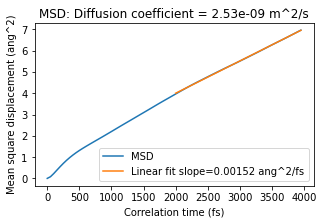

In [191]:
retrained_model_msd_job = get_msd_job(retrained_model_prod_md_job, "O")
retrained_model_D = (
    retrained_model_msd_job.results.get_diffusion_coefficient()
)  # diffusion coefficient, m^2/s
plot_msd(retrained_model_msd_job)

### Reference MSD, diffusion coefficient

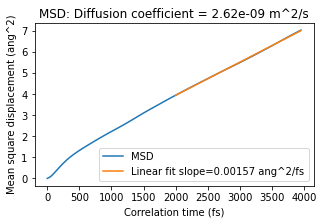

In [124]:
reference_msd_job = get_msd_job(reference_prod_md_job, "O")
reference_D = (
    reference_msd_job.results.get_diffusion_coefficient()
)  # diffusion coefficient, m^2/s
plot_msd(reference_msd_job)

**Conclusion for diffusion coefficient**: In this case, the retrained model gives 2.53e-9 m^2/s and the reference method 2.62e-9 m^2/s. That is very good agreement! Note: your results may be somewhat different.

### Retrained model and reference RDF

Let's compare the calculated O-O, O-H, and H-H radial distribution functions (rdf):

In [185]:
def get_rdf(job, atom_indices, atom_indices_to, rmin, rmax, rstep):
    rdf = plams.AMSRDFJob(
        job,
        atom_indices=atom_indices,
        atom_indices_to=atom_indices_to,
        rmin=rmin,
        rmax=rmax,
        rstep=rstep,
    )
    rdf.run()

    return rdf.results.get_rdf()


final_frame = (
    retrained_model_prod_md_job.results.get_main_molecule()
)  # doesn't matter if retrained model or reference
O_ind = [i for i, at in enumerate(final_frame, 1) if at.symbol == "O"]
H_ind = [i for i, at in enumerate(final_frame, 1) if at.symbol == "H"]
rmax = final_frame.lattice[0][0] / 2
rstep = 0.05

### O-O rdf

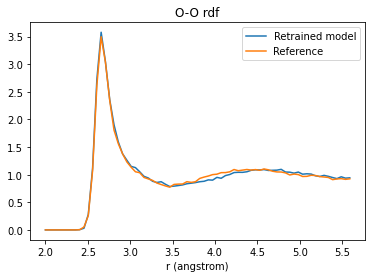

In [186]:
atom_indices, atom_indices_to = O_ind, O_ind
rmin = 2.0
pred_x, pred_y = get_rdf(
    retrained_model_prod_md_job, atom_indices, atom_indices_to, rmin, rmax, rstep
)
ref_x, ref_y = get_rdf(
    reference_prod_md_job, atom_indices, atom_indices_to, rmin, rmax, rstep
)
plt.plot(pred_x, pred_y, label="Retrained model")
plt.plot(ref_x, ref_y, label="Reference")
plt.xlabel("r (angstrom)")
plt.legend()
plt.title("O-O rdf");

### O-H rdf

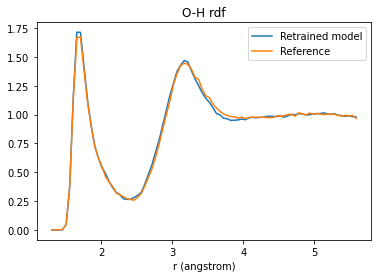

In [128]:
atom_indices, atom_indices_to = O_ind, H_ind
rmin = 1.3
pred_x, pred_y = get_rdf(
    retrained_model_prod_md_job, atom_indices, atom_indices_to, rmin, rmax, rstep
)
ref_x, ref_y = get_rdf(
    reference_prod_md_job, atom_indices, atom_indices_to, rmin, rmax, rstep
)
plt.plot(pred_x, pred_y, label="Retrained model")
plt.plot(ref_x, ref_y, label="Reference")
plt.xlabel("r (angstrom)")
plt.legend()
plt.title("O-H rdf");

### H-H rdf

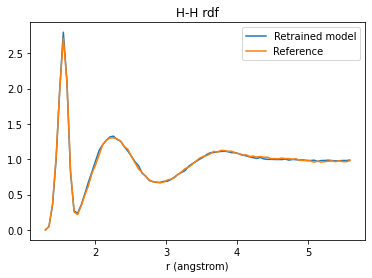

In [129]:
atom_indices, atom_indices_to = H_ind, H_ind
rmin = 1.3
pred_x, pred_y = get_rdf(
    retrained_model_prod_md_job, atom_indices, atom_indices_to, rmin, rmax, rstep
)
ref_x, ref_y = get_rdf(
    reference_prod_md_job, atom_indices, atom_indices_to, rmin, rmax, rstep
)
plt.plot(pred_x, pred_y, label="Retrained model")
plt.plot(ref_x, ref_y, label="Reference")
plt.xlabel("r (angstrom)")
plt.legend()
plt.title("H-H rdf");

### Turn PLAMS logging back on

In [187]:
plams.config.log.stdout = 3  # default value

## Density and NPT

### Check the predicted vs. reference density

In [135]:
npt_md_s = plams.AMSNPTJob(
    nsteps=100000,
    timestep=0.5,
    thermostat="NHC",
    tau=100,
    temperature=300,
    barostat="MTK",
    barostat_tau=1000,
    equal="XYZ",
    pressure=1e5,
).settings

In [136]:
retrained_model_npt_job = plams.AMSJob(
    settings=npt_md_s + retrained_model_settings,
    name="retrained_model_npt",
    molecule=retrained_model_prod_md_job.results.get_main_molecule(),
)

retrained_model_npt_job.run();

[22.02|15:25:22] JOB retrained_model_npt STARTED
[22.02|15:25:22] JOB retrained_model_npt RUNNING
[22.02|16:06:01] JOB retrained_model_npt FINISHED
[22.02|16:06:01] JOB retrained_model_npt SUCCESSFUL


In [147]:
retrained_model_density = (
    plams.AMSNPTJob.load_external(retrained_model_npt_job.results.rkfpath())
    .results.get_equilibrated_molecule()
    .get_density()
)
print(
    f"Retrained model water density at 300 K: {retrained_model_density*1e-3:.2f} g/cm^3"
)

Retrained model water density at 300 K: 0.95 g/cm^3


In [176]:
plams.config.jobmanager.hashing = None
reference_npt_job = plams.AMSJob(
    settings=npt_md_s + ref_s,
    name="reference_npt",
    molecule=reference_prod_md_job.results.get_main_molecule(),
)

reference_npt_job.run()

[22.02|18:53:54] JOB reference_npt STARTED
[22.02|18:53:54] Renaming job reference_npt to reference_npt.002
[22.02|18:53:54] JOB reference_npt.002 RUNNING
[22.02|18:58:13] JOB reference_npt.002 FINISHED
[22.02|18:58:13] JOB reference_npt.002 SUCCESSFUL


In [177]:
reference_density = (
    plams.AMSNPTJob.load_external(reference_npt_job.results.rkfpath())
    .results.get_equilibrated_molecule()
    .get_density()
)
print(f"Reference model water density at 300 K: {reference_density*1e-3:.2f} g/cm^3")

Reference model water density at 300 K: 1.01 g/cm^3


The above reference value for ReaxFF Water-2017.ff agrees exactly with the published reference value of 1.01 g/cm^3.

However, the retrained M3GNet model predicts a density of 0.95 g/cm^3. The agreement is reasonable but not excellent. This can be explained by the fact that almost all training data points were at 1.00 g/cm^3. Only a few points (from the "M3GNetShortMD" initial reference data generator) were taken at other densities.

Let's continue the active learning while sampling more densities. There are two strategies:

* Use an NPT simulation during the active learning
* Scan the density during the active learning

Here, we choose the second approach in order to ensure that multiple different densities are sampled.

### Initial structure for scanning density

Get the final frame from one of the previous MD simulations, and linearly scale the density to 800 kg/m^3 = 0.8 g/cm^3. This will stretch out the O-H bonds so follow up with a short UFF preoptimization.

In [203]:
new_structure = final_frame.copy()
new_structure.set_density(850)
new_structure = plams.preoptimize(new_structure, model="uff", maxiterations=20)

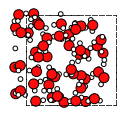

In [204]:
plams.plot_molecule(new_structure)

### Second active learning job: scanning density

Here we set Steps.Type = "Linear" to run reference calculations every 5000 MD steps.

To get an accurate density it's very important that the predicted energy is accurate. It is not enough to just get a good fit for the forces.

Here, we decrease the success criteria for both the energy and forces compared to default values.

In [205]:
nsteps = 80000
scan_density_md_s = plams.AMSMDScanDensityJob(
    molecule=new_structure,
    scan_density_upper=1.15,
    nsteps=nsteps,
    tau=100,
    thermostat="Berendsen",
    temperature=300,
).settings
# we must explicitly set the StopStep, since the AL divides the simulation into multiple segments
scan_density_md_s.input.ams.MolecularDynamics.Deformation.StopStep = nsteps

In [207]:
# job = SimpleActiveLearningJob.load_external(plams.config.default_jobmanager.workdir + "/sal.002")
scan_density_ml_s = ml_s.copy()
scan_density_ml_s.input.ams.MachineLearning.LoadModel = (
    job.results.get_params_results_directory()
)
scan_density_ml_s.input.ams.MachineLearning.Target.Forces.MAE = 0.02
scan_density_ml_s.input.ams.MachineLearning.MaxEpochs = 200

In [218]:
scan_density_al_s = plams.Settings()

scan_density_al_s.input.ams.ActiveLearning.Steps.Type = "Linear"
scan_density_al_s.input.ams.ActiveLearning.Steps.Linear.Start = 500
scan_density_al_s.input.ams.ActiveLearning.Steps.Linear.StepSize = 5000
scan_density_al_s.input.ams.ActiveLearning.InitialReferenceData.Load.FromPreviousModel = (
    "Yes"
)

scan_density_al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Relative = 0.001
scan_density_al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Total = 0.002
# because we do not set Normalization, the above Energy criteria are energies per atom
# scan_density_al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Normalization =

scan_density_al_s.input.ams.ActiveLearning.SuccessCriteria.Forces.MaxDeviationForZeroForce = (
    0.30
)

scan_density_al_s.input.ams.ActiveLearning.AtEnd.RerunSimulation = "No"
scan_density_al_s.input.ams.ActiveLearning.MaxReferenceCalculationsPerAttempt = 2

In [215]:
scan_density_al_job = SimpleActiveLearningJob(
    name="scan_density_al",
    settings=ref_s + scan_density_md_s + scan_density_ml_s + scan_density_al_s,
    molecule=new_structure,
)
scan_density_al_job.run(watch=True);

[23.02|13:01:42] Simple Active Learning 2024.101,  Nodes: 1, Procs: 1
[23.02|13:01:44] Composition of main system: H96O48
[23.02|13:01:44] All REFERENCE calculations will be performed with the following ReaxFF engine:
[23.02|13:01:44]
Engine reaxff
  forcefield Water2017.ff
EndEngine


[23.02|13:01:44] The following are the settings for the to-be-trained MACHINE LEARNING model:
[23.02|13:01:44]
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  LoadModel /home/hellstrom/adfhome/userdoc/Workflows/SimpleActiveLearning/PythonExamples/SALLiquidWater/plams_workdir.003/sal.002/step6_attempt1_training/results
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 300
  Target
    Forces
      MAE 0.02
    End
  End
End

ParallelLevels
End

[23.02|13:01:44] A single model will be trained (no committee).
[23.02|13:01:44] The ACTIVE LEARNING loop will contain 17 steps, using the following schema:
[23.02|13:01:44]    Active Learning Step   1:      500 MD Steps (cumulative:      500)
[23.02|13:

Let's recalculate the density again:

In [216]:
new_retrained_model_settings = (
    scan_density_al_job.results.get_params_job().results.get_production_engine_settings()
)

new_retrained_model_npt_job = plams.AMSJob(
    settings=npt_md_s + new_retrained_model_settings,
    name="new_retrained_model_npt",
    molecule=retrained_model_prod_md_job.results.get_main_molecule(),
)

new_retrained_model_npt_job.run();

In [217]:
new_retrained_model_density = (
    plams.AMSNPTJob.load_external(new_retrained_model_npt_job.results.rkfpath())
    .results.get_equilibrated_molecule()
    .get_density()
)
print(
    f"New retrained model water density at 300 K: {new_retrained_model_density*1e-3:.2f} g/cm^3"
)

New retrained model water density at 300 K: 1.02 g/cm^3


**Conclusion for the density**: Using active learning when scanning the densities makes sure that the predicitons are accurate for all densities. Consequently the equilibrium density is also in better agreement with the reference value of 1.01 g/cm^3.

Note that the density in general is quite difficult to fit accurately.